This notebook builds on my previous work -- [co-visitation matrix - simplified, imprvd logic 🔥](https://www.kaggle.com/code/radek1/co-visitation-matrix-simplified-imprvd-logic?scriptVersionId=110068977) that achieves 0.558 on the LB.

Here we take the functionality from that notebook, run on 1/1000 of the data (it achieves ~0.487 on public LB).

The next step in improving our results is to create a robust local validation framework to facilitate experimentation. This can be a stepping stone towards a much stronger result.

Let's take a stab at implementing a local validation framework in this notebook!

<strong>Please smash that thumbs up button if you like this notebook! Thank you! 🙂</strong>

In [ ]:
import pandas as pd
import numpy as np
!pip install pickle5
import pickle5 as pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 4.4 MB/s eta 0:00:00a 0:00:01


In [ ]:
%%time
train = pd.read_parquet('../input/otto-full-optimized-memory-footprint/train.parquet')

CPU times: user 8.54 s, sys: 9 s, total: 17.5 s
Wall time: 19.8 s


In [ ]:
# did we actually used the test from here in original Radek's code? (It seems not)
# test = pd.read_parquet('../input/otto-full-optimized-memory-footprint/test.parquet') 

In [ ]:
DO_LOCAL_VALIDATION = True

# Local CV

For local CV, we will use the last weeks data of train for validation.

Essentially, without modifying the calculations in the notebook, we can run evaluation locally if we replace the contents of the `train` and `test` variables.

When doing local validation, we will print out local results. And without it, we will train on full data and submit to Kaggle LB.

## Find the start and end datetime of training sessions

In [ ]:
ts_min, ts_max = train.ts.min(), train.ts.max()
ts_min, ts_max

(1659304800, 1661723999)

In [ ]:
import datetime

In [ ]:
help(datetime.datetime.fromtimestamp)

Help on built-in function fromtimestamp:

fromtimestamp(...) method of builtins.type instance
    timestamp[, tz] -> tz's local time from POSIX timestamp.



## datetime.datetime.fromtimestamp(ts_min/1000) make no sense to me

In [ ]:
datetime.datetime.fromtimestamp(ts_min), datetime.datetime.fromtimestamp(ts_max), \
datetime.datetime.fromtimestamp(ts_min/1000), datetime.datetime.fromtimestamp(ts_max/1000) 

(datetime.datetime(2022, 7, 31, 22, 0),
 datetime.datetime(2022, 8, 28, 21, 59, 59),
 datetime.datetime(1970, 1, 20, 4, 55, 4, 800000),
 datetime.datetime(1970, 1, 20, 5, 35, 23, 999000))

## `7*24*60*60*1000` won't make the actual 7 days

If 7 days is `7*24*60*60*1000` (604_800_000), then there is no cutoff which stays between ts_max and ts_min

In [ ]:
seven_days = 7*24*60*60*1000 # 604_800_000
train_cutoff = ts_max - seven_days # 1_056_923_999 = 1_661_723_999 - 604_800_000
ts_max > ts_min > train_cutoff

True

The cut is not 7 days from the last day, but 7000 days from the last day

In [ ]:
datetime.datetime.fromtimestamp(0), datetime.datetime.fromtimestamp(train_cutoff), datetime.datetime.fromtimestamp(ts_min), datetime.datetime.fromtimestamp(ts_max), \

(datetime.datetime(1970, 1, 1, 0, 0),
 datetime.datetime(2003, 6, 29, 21, 59, 59),
 datetime.datetime(2022, 7, 31, 22, 0),
 datetime.datetime(2022, 8, 28, 21, 59, 59))

If 7 days is `7*24*60*60` (604_800), then the cutoff which can stay between ts_max and ts_min, and cutoff is at the 7 days from the last day

In [ ]:
seven_days = 7*24*60*60 # 604_800
train_cutoff = ts_max - seven_days # 1_056_923_999 = 1_661_723_999 - 604_800
ts_max > train_cutoff > ts_min

True

In [ ]:
datetime.datetime.fromtimestamp(0), datetime.datetime.fromtimestamp(train_cutoff), \
datetime.datetime.fromtimestamp(ts_min), datetime.datetime.fromtimestamp(ts_max), \

(datetime.datetime(1970, 1, 1, 0, 0),
 datetime.datetime(2022, 8, 21, 21, 59, 59),
 datetime.datetime(2022, 7, 31, 22, 0),
 datetime.datetime(2022, 8, 28, 21, 59, 59))

## How big is train, local_train, local_test

In [ ]:
train.shape, train.memory_usage() # 216_716_096 rows

((216716096, 4),
 Index            128
 session    866864384
 aid        866864384
 ts         866864384
 type       216716096
 dtype: int64)

In [ ]:
local_train = train[train.ts <= train_cutoff] # 163_955_181 rows, and RAM on session metrics doubled from 4.6G to 9.1G

In [ ]:
# run
local_train.shape, local_train.memory_usage() # the Index is a huge number on RAM

((163955181, 4),
 Index      1311641448
 session     655820724
 aid         655820724
 ts          655820724
 type        163955181
 dtype: int64)

In [ ]:
# run
local_test = train[train.ts > train_cutoff] # 52_760_915 rows, and RAM raise from 9.1G to 10.1G

In [ ]:
# run 
local_test.shape, local_test.memory_usage() # the Index is a huge number on RAM

((52760915, 4),
 Index      422087320
 session    211043660
 aid        211043660
 ts         211043660
 type        52760915
 dtype: int64)

## Can we save the RAM by making the index smaller? 
https://stackoverflow.com/questions/54603378/pandas-convert-from-int64index-to-rangeindex

In [ ]:
# help(train.reset_index) 
#     >>> df = pd.DataFrame([('bird', 389.0),
#     ...                    ('bird', 24.0),
#     ...                    ('mammal', 80.5),
#     ...                    ('mammal', np.nan)],
#     ...                   index=['falcon', 'parrot', 'lion', 'monkey'],
#     ...                   columns=('class', 'max_speed'))
#     >>> df
#              class  max_speed
#     falcon    bird      389.0
#     parrot    bird       24.0
#     lion    mammal       80.5
#     monkey  mammal        NaN
    
#     When we reset the index, the old index is added as a column, and a
#     new sequential index is used:
    
#     >>> df.reset_index()
#         index   class  max_speed
#     0  falcon    bird      389.0
#     1  parrot    bird       24.0
#     2    lion  mammal       80.5
#     3  monkey  mammal        NaN
    
#     We can use the `drop` parameter to avoid the old index being added as
#     a column:
    
#     >>> df.reset_index(drop=True)
#         class  max_speed
#     0    bird      389.0
#     1    bird       24.0
#     2  mammal       80.5
#     3  mammal        NaN

In [ ]:
train.index, local_train.index, local_test.index # RangeIndex vs Int64Index

(RangeIndex(start=0, stop=216716096, step=1),
 Int64Index([        0,         1,         2,         3,         4,         5,
                     6,         7,         8,         9,
             ...
             201331366, 201331419, 201331437, 201331440, 201331459, 201331461,
             201331464, 201331469, 201331485, 201331512],
            dtype='int64', length=163955181),
 Int64Index([      147,       148,       149,       150,       151,       152,
                   153,       154,       155,       156,
             ...
             216716086, 216716087, 216716088, 216716089, 216716090, 216716091,
             216716092, 216716093, 216716094, 216716095],
            dtype='int64', length=52760915))

### convert index from Int64Range to RangeIndex

In [ ]:
local_train.reset_index(inplace=True, drop=True) # no effect on RAM from the session metrics board
local_train.index, local_train.memory_usage() # but the number for Index dropped drastically

(RangeIndex(start=0, stop=163955181, step=1),
 Index            128
 session    655820724
 aid        655820724
 ts         655820724
 type       163955181
 dtype: int64)

In [ ]:
local_test.reset_index(inplace=True, drop=True) # no effect on RAM from the session metrics board
local_test.index, local_test.memory_usage() # but the number for Index dropped drastically

(RangeIndex(start=0, stop=52760915, step=1),
 Index            128
 session    211043660
 aid        211043660
 ts         211043660
 type        52760915
 dtype: int64)

In [ ]:
del train # RAM dropped from 10.1G to 7.5G according to session metrics

## remove intersecting sessions between local_train and local_test from local_test

In [ ]:
%%time
overlapping_sessions = set(local_train.session).intersection(set(local_test.session)) # not use use RAM

CPU times: user 25.9 s, sys: 2.16 s, total: 28.1 s
Wall time: 27.8 s


In [ ]:
len(overlapping_sessions), local_train.session.unique().shape[0], local_test.session.unique().shape[0] 
# 3_521_833, 11_098_528, 5_323_084

(3521833, 11098528, 5323084)

In [ ]:
%%time
local_test = local_test[~local_test.session.isin(overlapping_sessions)] # RAM raise from 7.5 to 7.9
local_test.index, local_test.memory_usage()

CPU times: user 2.07 s, sys: 387 ms, total: 2.45 s
Wall time: 2.45 s


(Int64Index([37376338, 37376339, 37376340, 37376341, 37376342, 37376343,
             37376344, 37376345, 37376346, 37376347,
             ...
             52760905, 52760906, 52760907, 52760908, 52760909, 52760910,
             52760911, 52760912, 52760913, 52760914],
            dtype='int64', length=15384577),
 Index      123076616
 session     61538308
 aid         61538308
 ts          61538308
 type        15384577
 dtype: int64)

In [ ]:
local_test.reset_index(inplace=True, drop=True) # but not reduce RAM according to session metrics, stays at 7.9G
local_test.index, local_test.memory_usage()

(RangeIndex(start=0, stop=15384577, step=1),
 Index           128
 session    61538308
 aid        61538308
 ts         61538308
 type       15384577
 dtype: int64)

## There is no empty rows in any sessions of local_test

In [ ]:

count_zero = local_test.groupby('session')['aid'].count().apply(lambda x: x == 0)
count_one = local_test.groupby('session')['aid'].count().apply(lambda x: x > 0)

In [ ]:
sum(count_zero), sum(count_one), local_test.session.unique().shape[0]

(0, 1801251, 1801251)

## split data samples for local test and local validation

In [ ]:
%%time
new_test = []
data_to_calculate_validation_score = []

for grp in local_test.groupby('session'): # loop each session of local_test
    # select a random row from the session as cutoff row, we want at least a single item in our validation data for each session
    cutoff = np.random.randint(1, grp[1].shape[0]) 
    new_test.append(grp[1].iloc[:cutoff]) # take the left part from cutoff as data samples for local test
    data_to_calculate_validation_score.append(grp[1].iloc[cutoff:]) # take the right part from the cutoff as data samples for local validation

CPU times: user 2min 44s, sys: 10.5 s, total: 2min 55s
Wall time: 2min 55s


In [ ]:
%%time
test = pd.concat(new_test).reset_index(drop=True) # stack a list of smaller dfs onto each otehr
valid = pd.concat(data_to_calculate_validation_score).reset_index(drop=True) # maximum to 24G

CPU times: user 6min 3s, sys: 18.2 s, total: 6min 21s
Wall time: 6min 21s


In [ ]:
test.shape, test.memory_usage(), valid.shape, valid.memory_usage()

((7695335, 4),
 Index           128
 session    30781340
 aid        30781340
 ts         30781340
 type        7695335
 dtype: int64,
 (7689242, 4),
 Index           128
 session    30756968
 aid        30756968
 ts         30756968
 type        7689242
 dtype: int64)

In [ ]:
%%time
test.to_parquet('_test.parquet') # save to a parquet file
valid.to_parquet('_valid.parquet')

del new_test, data_to_calculate_validation_score # now dropped to 9.8G

CPU times: user 16.8 s, sys: 2.03 s, total: 18.8 s
Wall time: 18.7 s


In [ ]:
del local_test # from 9.8G down to 9.3G according to session metrics

In [ ]:
train = local_train

In [ ]:
DO_LOCAL_VALIDATION = True

We have now swapped the train and test sets for the ones we conjured and can now proceed to train as we would normally.

# Train

## Create subsets for experiments from local_train (now, known as train)

In [ ]:
fraction_of_sessions_to_use = 1/1000

In [ ]:
%%time

lucky_sessions_train = train.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use)['session']
subset_of_train = train[train.session.isin(lucky_sessions_train)]

lucky_sessions_test = test.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use)['session']
subset_of_test = test[test.session.isin(lucky_sessions_test)]

# now session metrics reports RAM to be 10.5GB

CPU times: user 9.1 s, sys: 1.06 s, total: 10.2 s
Wall time: 10.2 s


### Add session as index for the subsets (train and test)

In [ ]:
subset_of_train.index = pd.MultiIndex.from_frame(subset_of_train[['session']])
subset_of_test.index = pd.MultiIndex.from_frame(subset_of_test[['session']]) # now effect on RAM

In [ ]:
subset_of_train.shape, subset_of_train.session.unique().shape[0], subset_of_test.shape, subset_of_test.session.unique().shape[0],

((164323, 4), 11099, (7507, 4), 1801)

In [ ]:
%%time

all_consecutive_AIDs = [] 
chunk_size = 60_000

sessions = subset_of_train.session.unique() # all unique sessions of subset_of_train
for i in range(0, sessions.shape[0], chunk_size): # loop every 60_000 sessions, not rows (each session has multiple rows)
    # take every 60_000 sessions (with all rows in each session) put into a new df named current_chunk (also remove session as index)
    current_chunk = subset_of_train.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True)
    # update current_chunk by selecting the last 30 rows of each session (make sure no additional index)
    current_chunk = current_chunk.groupby('session').apply(lambda g: g.tail(30)).reset_index(drop=True)
    # @radek1 has a nice explanation on this line of code, see the cell below
    # consecutive_AIDs contains 60_000 sessions, each aid has paired with every aids    
    consecutive_AIDs = current_chunk.merge(current_chunk, on='session')
    # remove all rows where the pair of aids are the same
    consecutive_AIDs = consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]
    # add a column named 'days_elapsed' to record how many days passed between two aids
    # whether divided by 1000 or not should make no difference in RAM, as they are all float64 type
    consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60 * 1000)
    # select only rows where first aid comes before second aid and both occurred in the same day
    consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed > 0) & (consecutive_AIDs.days_elapsed <= 1)]
    # put every 60_000 session df processed above into a list
    all_consecutive_AIDs.append(
        consecutive_AIDs
    )

CPU times: user 3.78 s, sys: 86.2 ms, total: 3.87 s
Wall time: 3.86 s


#### How @radek1 explains `current_chunk.merge(current_chunk, on='session')` above from [discussion](https://www.kaggle.com/code/radek1/co-visitation-matrix-simplified-imprvd-logic/comments#2031136)
so that we can create a cartesian product of aids

essentially, it is a trick to create aid pairs by session

if a user had three aids in a session 1, 2, 3 this will create all possible pairs [1, 1], [1,2], [1,3], [2,1]… etc

### apply the same logic above to the subset_of_test, and append them to consecutive_AIDs

In [ ]:
%%time
sessions = subset_of_test.session.unique()
for i in range(0, sessions.shape[0], chunk_size):
    current_chunk = subset_of_test.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True)
    current_chunk = current_chunk.groupby('session').apply(lambda g: g.tail(30)).reset_index(drop=True)
    consecutive_AIDs = current_chunk.merge(current_chunk, on='session')
    consecutive_AIDs = consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]
    consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60 * 1000)
    consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed > 0) & (consecutive_AIDs.days_elapsed <= 1)]
    all_consecutive_AIDs.append(
        consecutive_AIDs
    )

CPU times: user 513 ms, sys: 2 ms, total: 515 ms
Wall time: 513 ms


### stack all dfs inside all_consecutive_AIDs into a single df and remove the rows when their session, aid_x, aid_y are the same

In [ ]:
%%time
all_consecutive_AIDs = pd.concat(all_consecutive_AIDs).drop_duplicates(['session', 'aid_x', 'aid_y'])[['aid_x', 'aid_y']]

CPU times: user 137 ms, sys: 962 µs, total: 138 ms
Wall time: 135 ms


In [ ]:
all_consecutive_AIDs.head()

,aid_x,aid_y
1,236819,4268
2,236819,994930
8,236819,305933
11,236819,569669
18,4268,994930


## Create a Counter with defaultdict to count the num of occurrences of other aids given each aid

In [ ]:
%%time

from collections import defaultdict, Counter

next_AIDs = defaultdict(Counter)

for row in all_consecutive_AIDs.itertuples():
    next_AIDs[row.aid_x][row.aid_y] += 1

CPU times: user 861 ms, sys: 21 ms, total: 882 ms
Wall time: 881 ms


In [ ]:
for k,v in next_AIDs.items(): 
    print(k)
    print(v)
    break

236819
Counter({4268: 1, 994930: 1, 305933: 1, 569669: 1})


In [ ]:
len(next_AIDs)

49916

## Now let's generate the predictions.

In [ ]:
test.groupby('session')['aid'].apply(list)

session
11098528    [11830, 1679529, 92401, 1055218, 1561739, 1679...
11098529                                            [1105029]
11098530     [264500, 264500, 409236, 409236, 409236, 409236]
11098531    [452188, 1239060, 1557766, 452188, 396199, 130...
11098532                     [7651, 876469, 1596491, 1550739]
                                  ...                        
12899774                                              [33035]
12899775                                            [1743151]
12899776                                             [548599]
12899777                                             [384045]
12899778                                             [561560]
Name: aid, Length: 1801251, dtype: object

In [ ]:
%%time
# get aid into a list for every session in the processed local_test
test_session_AIDs = test.groupby('session')['aid'].apply(list)
test_session_AIDs.head()

CPU times: user 34.3 s, sys: 434 ms, total: 34.8 s
Wall time: 34.8 s


session
11098528    [11830, 1679529, 92401, 1055218, 1561739, 1679...
11098529                                            [1105029]
11098530     [264500, 264500, 409236, 409236, 409236, 409236]
11098531    [452188, 1239060, 1557766, 452188, 396199, 130...
11098532                     [7651, 876469, 1596491, 1550739]
Name: aid, dtype: object

In [ ]:
session_types = ['clicks', 'carts', 'orders']

### rd: recsys - otto - robust local validation - debug a block of code by making it a func and use print and return

**The original code** here and see debuggable version in the next cell
```python
labels = []

for AIDs in test_session_AIDs: # loop each session to get its list of aids
    AIDs = list(dict.fromkeys(AIDs[::-1])) # reverse the order of the list of aids and remove duplicated aids and return a list
    if len(AIDs) >= 20: # if there are more than 20 aids in the session, then takes the first 20 aids into labels (a list)
        labels.append(AIDs[:20])
    else:
        counter = Counter()
        for AID in AIDs: # loop every aid of the list of aid from the session
            subsequent_AID_counter = next_AIDs.get(AID) # use next_AIDs to access all the pair partners of AID, which is a counter
            # if the counter exist, merge subsequent_AID_counter to counter (counter is still a single counter with a lot more items each time)
            if subsequent_AID_counter:
                counter += subsequent_AID_counter
        # now, counter is a Counter contains a Counter of other aids for every aid in a session (which means a lot of other aids counts)
        # take the 40 most common other aids, if they are not already in AIDs, then add them to AIDs
        AIDs += [AID for AID, cnt in counter.most_common(40) if AID not in AIDs]
        # in the end only take the first 20 aids into labels for each session
        labels.append(AIDs[:20])
```

In [ ]:
%%time
def f():
    labels = []

    for AIDs in test_session_AIDs: # loop each session to get its list of aids
        AIDs = list(dict.fromkeys(AIDs[::-1])) # reverse the order of the list of aids and remove duplicated aids and return a list
        if len(AIDs) >= 20: # if there are more than 20 aids in the session, then takes the first 20 aids into labels (a list)
            labels.append(AIDs[:20])
        else:
            counter = Counter()
#             idx = 0
            for AID in AIDs: # loop every aid of the list of aid from the session
                subsequent_AID_counter = next_AIDs.get(AID) # use next_AIDs to access all the pair partners of AID, which is a counter
                # if the counter exist, merge subsequent_AID_counter to counter (counter is still a single counter with a lot more items each time)
                if subsequent_AID_counter:
#                     idx+=1
                    counter += subsequent_AID_counter
#                     print(f"subsequent_AID_counter: {subsequent_AID_counter}")
#                     print(f"counter: {counter}")
#                     print()
#                     if idx>1:
#                         return

            # now, counter is a Counter contains a Counter of other aids for every aid in a session (which means a lot of other aids counts)
            # take the 40 most common other aids, if they are not already in AIDs, then add them to AIDs
#             print(counter.most_common(40))
#             help(counter.most_common)
#             return
            AIDs += [AID for AID, cnt in counter.most_common(40) if AID not in AIDs]
            # in the end only take the first 20 aids into labels for each session
            labels.append(AIDs[:20])
    
    return labels

labels = f()

CPU times: user 1min 2s, sys: 466 ms, total: 1min 2s
Wall time: 1min 2s


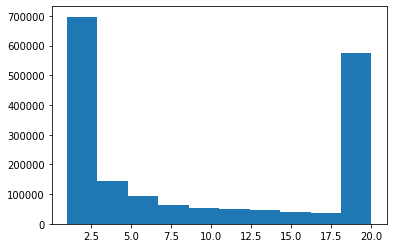

In [ ]:
from matplotlib import pyplot as plt

plt.hist([len(l) for l in labels]);

## Prepare the submission format

### make the list of aids into a string

In [ ]:
labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels]
predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})
labels_as_strings[:2]
predictions.head()

,session_type,labels
0,11098528,369774 440367 11830 1033148 990658 1199737 167...
1,11098529,1105029
2,11098530,409236 264500 860 492245 1151358
3,11098531,1553691 1271998 396199 1728212 1365569 1557766...
4,11098532,1550739 1596491 876469 7651 1402537 123224 400...


In [ ]:
prediction_dfs = []

for st in session_types:
    modified_predictions = predictions.copy()
    modified_predictions.session_type = modified_predictions.session_type.astype('str') + f'_{st}'
    prediction_dfs.append(modified_predictions)

In [ ]:
prediction_dfs[0].head()

,session_type,labels
0,11098528_clicks,369774 440367 11830 1033148 990658 1199737 167...
1,11098529_clicks,1105029
2,11098530_clicks,409236 264500 860 492245 1151358
3,11098531_clicks,1553691 1271998 396199 1728212 1365569 1557766...
4,11098532_clicks,1550739 1596491 876469 7651 1402537 123224 400...


In [ ]:
prediction_dfs[1].head()

,session_type,labels
0,11098528_carts,369774 440367 11830 1033148 990658 1199737 167...
1,11098529_carts,1105029
2,11098530_carts,409236 264500 860 492245 1151358
3,11098531_carts,1553691 1271998 396199 1728212 1365569 1557766...
4,11098532_carts,1550739 1596491 876469 7651 1402537 123224 400...


In [ ]:
prediction_dfs[2].head()

,session_type,labels
0,11098528_orders,369774 440367 11830 1033148 990658 1199737 167...
1,11098529_orders,1105029
2,11098530_orders,409236 264500 860 492245 1151358
3,11098531_orders,1553691 1271998 396199 1728212 1365569 1557766...
4,11098532_orders,1550739 1596491 876469 7651 1402537 123224 400...


In [ ]:
submission = pd.concat(prediction_dfs).reset_index(drop=True)
submission.head()

,session_type,labels
0,11098528_clicks,369774 440367 11830 1033148 990658 1199737 167...
1,11098529_clicks,1105029
2,11098530_clicks,409236 264500 860 492245 1151358
3,11098531_clicks,1553691 1271998 396199 1728212 1365569 1557766...
4,11098532_clicks,1550739 1596491 876469 7651 1402537 123224 400...


# We either submit to Kaggle or run validation locally

We need to now reverse the processing we applied to our predictions to shape them into a submission.

I am undoing this work here on purpose. I will replace the code I use for predictions down the road, so I want my evaluation framework to work with data formatted like for making a submission.

In [ ]:
with open('../input/otto-full-optimized-memory-footprint/id2type.pkl', "rb") as fh:
    id2type = pickle.load(fh)
with open('../input/otto-full-optimized-memory-footprint/type2id.pkl', "rb") as fh:
    type2id = pickle.load(fh)
    
sample_sub = pd.read_csv('../input/otto-recommender-system/sample_submission.csv')

In [ ]:
sample_sub.head()

,session_type,labels
0,12899779_clicks,129004 126836 118524
1,12899779_carts,129004 126836 118524
2,12899779_orders,129004 126836 118524
3,12899780_clicks,129004 126836 118524
4,12899780_carts,129004 126836 118524


In [ ]:
%%time
if DO_LOCAL_VALIDATION:
    # convert back for experiment
    submission['session'] = submission.session_type.apply(lambda x: int(x.split('_')[0]))
    submission['type'] = submission.session_type.apply(lambda x: x.split('_')[1])
    submission.labels = submission.labels.apply(lambda x: [int(i) for i in x.split(' ')])

    # convert type from idx to string-type for validation set
    valid.type = valid.type.map(lambda idx: id2type[idx])
    # group by session, then group by type, to access all aids, and make all aids into a list
    ground_truth = valid.groupby(['session', 'type'])['aid'].apply(list)
    # remove index and rename column aid to labels
    ground_truth = ground_truth.reset_index().rename(columns={'aid': 'labels'})
    # 
    ground_truth.loc[ground_truth.type == 'clicks', 'labels'] = ground_truth.loc[ground_truth.type == 'clicks', 'labels'].str[-1:]

    submission_with_gt = submission.merge(ground_truth[['session', 'type', 'labels']], how='left', on=['session', 'type'])
    submission_with_gt = submission_with_gt[~submission_with_gt.labels_y.isna()]
    submission_with_gt['hits'] = submission_with_gt.apply(lambda df: len(set(df.labels_x).intersection(set(df.labels_y))), axis=1)
    submission_with_gt['gt_count'] = submission_with_gt.labels_y.str.len()

    recall_per_type = submission_with_gt.groupby(['type'])['hits'].sum() / submission_with_gt.groupby(['type'])['gt_count'].sum() 
    local_validation_score = (recall_per_type * pd.Series({'clicks': 0.10, 'carts': 0.30, 'orders': 0.60})).sum()
    print(f'Local validation score: {local_validation_score}')

else:
    submission.to_csv('submission.csv', index=False)


Local validation score: 0.4439805579019317
CPU times: user 2min 32s, sys: 4.54 s, total: 2min 37s
Wall time: 2min 37s


## Experiment to figure what some lines do

In [ ]:
submission = pd.concat(prediction_dfs).reset_index(drop=True)
submission.head()

,session_type,labels
0,11098528_clicks,369774 440367 11830 1033148 990658 1199737 167...
1,11098529_clicks,1105029
2,11098530_clicks,409236 264500 860 492245 1151358
3,11098531_clicks,1553691 1271998 396199 1728212 1365569 1557766...
4,11098532_clicks,1550739 1596491 876469 7651 1402537 123224 400...


In [ ]:

def f():
    if DO_LOCAL_VALIDATION:
        # convert back for experiment
        submission['session'] = submission.session_type.apply(lambda x: int(x.split('_')[0]))
        submission['type'] = submission.session_type.apply(lambda x: x.split('_')[1])
        submission.labels = submission.labels.apply(lambda x: [int(i) for i in x.split(' ')])

        # convert type from idx to string-type for validation set
        valid.type = valid.type.map(lambda idx: id2type[idx])
        # group by session, then group by type, to access all aids, and make all aids into a list
        ground_truth = valid.groupby(['session', 'type'])['aid'].apply(list)
#         print(ground_truth)
#         return
        # remove index and rename column aid to labels (no more aid as column)
        ground_truth = ground_truth.reset_index().rename(columns={'aid': 'labels'})
#         print(ground_truth)
#         return
        # debug to figure out what does .str[-1:] do: to get the last aid of the labels as the only label for each row if the type is clicks
        ground_truth.loc[ground_truth.type == 'clicks', 'labels'] = ground_truth.loc[ground_truth.type == 'clicks', 'labels'].str[-1:]
#         print(ground_truth)
#         return        
        # how to merge submission with ground_truth on session and type
        submission_with_gt = submission.merge(ground_truth[['session', 'type', 'labels']], how='left', on=['session', 'type'])
#         print(submission_with_gt)
#         return         
        # make sure rows with ground_truth.label as na is not selected
        submission_with_gt = submission_with_gt[~submission_with_gt.labels_y.isna()]
        # create a column for submission_with_gt to check which rows has labels_x and labels_y have aid intersections (true or false)
        submission_with_gt['hits'] = submission_with_gt.apply(lambda df: len(set(df.labels_x).intersection(set(df.labels_y))), axis=1)
        # add a column to count the ground truth or the number of aids of labels_y (turn labels_y into a string, 
        # len() of it can tell us how many aids are there)
        submission_with_gt['gt_count'] = submission_with_gt.labels_y.str.len()
        print(submission_with_gt)
        return         

        # calc recall for each type
        recall_per_type = submission_with_gt.groupby(['type'])['hits'].sum() / submission_with_gt.groupby(['type'])['gt_count'].sum() 
        # calc validation score with recall and then print it
        local_validation_score = (recall_per_type * pd.Series({'clicks': 0.10, 'carts': 0.30, 'orders': 0.60})).sum()
        print(f'Local validation score: {local_validation_score}')

    else:
        submission.to_csv('submission.csv', index=False)

submission = pd.concat(prediction_dfs).reset_index(drop=True)
valid = pd.read_parquet('_valid.parquet')
f()

            session_type                                           labels_x  \
0        11098528_clicks  [369774, 440367, 11830, 1033148, 990658, 11997...   
1        11098529_clicks                                          [1105029]   
3        11098531_clicks  [1553691, 1271998, 396199, 1728212, 1365569, 1...   
4        11098532_clicks  [1550739, 1596491, 876469, 7651, 1402537, 1232...   
5        11098533_clicks  [144447, 1493503, 1233050, 23678, 941187, 7613...   
...                  ...                                                ...   
5403303  12899329_orders                                          [1333457]   
5403311  12899337_orders  [558573, 1584505, 1046124, 899637, 698100, 877...   
5403329  12899355_orders  [1115942, 465366, 1439071, 933686, 1446430, 20...   
5403347  12899373_orders  [1766353, 995962, 487949, 1265534, 320314, 873...   
5403499  12899525_orders  [1488793, 1599360, 127479, 996393, 531353, 101...   

          session    type                   labels_